# <a href="https://thetahat.ru/courses/ad" target="_top">Введение в анализ данных</a>
## Домашнее задание 6. Основы обработки текстов


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@thetahat_ds25_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**. Если вы строите интерактивные графики, их стоит прислать в формате html.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания всем участникам списывания дается штраф -2 балла к итоговой оценке за семестр.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Обратите внимание на <a href="https://thetahat.ru/courses/ai-rules"><b>правила использования ИИ-инструментов</b></a> при решении домашнего задания.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Решение проверяется системой ИИ-проверки <a href="https://thetahat.ru/"><img src="https://miptstats.github.io/theta_grader_small.png" style="display: inline; vertical-align: middle;"></a> **ThetaGrader**. Результат проверки валидируется и исправляется человеком, после чего комментарии отправляются студентам.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.


<b><font size="5" color="red">Важно!!! Правила заполнения ноутбука:</font></b>
* Запрещается удалять имеющиеся в ноутбуке ячейки, менять местами положения задач.
* Сохраняйте естественный линейный порядок повествования в ноутбуке сверху-вниз.
* Отвечайте на вопросы, а также добавляйте новые ячейки в предложенных местах, которые обозначены `<...>`.
* В markdown-ячейка, содержащих описание задачи, находятся специальные отметки, которые <font color="red"><b>запрещается модифицировать</b></font>.
* При нарушении данных правил работа может получить 0 баллов.

**Баллы за задание:**

* Задача 1 &mdash; 100 баллов
* Задача 2 &mdash; 50 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [ ]:
# Bot check

# HW_ID: fpmi_ad6
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [ ]:
import re
import time
from collections import Counter, OrderedDict
from string import punctuation
from typing import List

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

nltk.download("stopwords")
sns.set(style="whitegrid", palette="Set2")

device = (
    "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
)

Перед выполнением задания **обязательно посмотрите** <a href="https://thetahat.ru/files/ad/main/6/lec6.pdf" target="_blank" rel="noopener noreferrer">презентацию</a>, <a href="https://thetahat.ru/courses/ad/main/6/nlp_sem_part1" target="_top">ноутбук</a> по RNN и <a href="https://thetahat.ru/courses/ad/main/6/nlp_sem_part2" target="_top">ноутбук</a> по LLM.

---
### Задача 1. Предсказание заработной платы


В этой задаче вам предлагается решить задачу регрессии &mdash; по текстовому описанию вакансии определить заработную плату. Для решения такой задачи можно применять различные методы, в том числе и те, которые были рассмотрены на лекции.
Мы будем решать эту задачу с помощью рекуррентной нейронной сети.

Датасет `salary_dataset.csv` лежит по <a target="_top" href="https://drive.google.com/file/d/1725ZmFblqrmnyNmqBfUA-7_Yt6RIpf9p/view?usp=sharing">ссылке</a>.

Если вы работаете локально:

> Просто скачайте этот файл и укажите пути к ним ниже.


Если вы используете <a target="_top" href="https://colab.research.google.com/">Colab</a>:
> **Скачивать файл не обязательно**. Просто подключитесь к Google Drive:
>
> ```
> from google.colab import drive
> drive.mount('/content/drive/')
> ```
>
> Перейдите по ссылке файла и добавьте shortcut на него в ваш собственный диск:
> 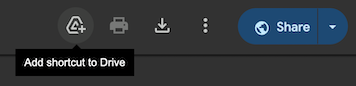

**1.** Скачаем данные для обучения и тестирования:

In [ ]:
dataset = pd.read_csv("salary_data.csv")
dataset.head()

Каждая строка содержит полное описание вакансии и соответствующую зарплату. При этом описания могут быть довольно длинными, например:

In [ ]:
dataset.iloc[0]["FullDescription"]

Для данной задачи нам не будут нужны служебные части речи и знаки пунктуации. Зададим функцию-токенизатор, списки стоп-слов и пунктуации.

In [ ]:
def simple_tokenize(text: str) -> List[str]:
    """Базовая предобработка и токенизация по словам"""
    # Приведение к нижнем регистру
    text = ...
    # Убираем пунктуацию, заменяя её на пробел
    text = re.sub(r"[^\w\s]", " ", text)
    # Разбиваем текст на слова
    tokens = ...
    return tokens


stop_words = nltk.corpus.stopwords.words("english")  # стоп-слова
punc = list(punctuation)  # пунктуация

Подготовьте словарь, оставив в нем только наиболее часто встречающиеся токены. Не забудьте предварительно убрать из предложений знаки пунктуации и стоп-слова.

*Можно использовать код с <a href="https://thetahat.ru/courses/ad/main/6/nlp_sem_part1" target="_top">семинара</a>.*

In [ ]:
ordered_dict = ...

Этот упорядоченный словарь хранит слово и его встречаемость. Можно посмотреть на самые частые слова в датасете:

In [ ]:
list(ordered_dict.items())[:10]

Создайте класс `Vocabulary`, отвечающий за управление словарём токенов. Добавьте к нему специальные токены, которые необходимы для подготовки данных к обучению.

*Можно воспользоваться кодом с <a href="https://thetahat.ru/courses/ad/main/6/nlp_sem_part1" target="_top">семинара</a>.*

In [ ]:
class Vocabulary:
    """
    Класс для создания и управления словарем токенов, обеспечивающий
    преобразование между токенами и их индексами.

    ...
    """

    ...


# Создание словаря
vocab = Vocabulary(ordered_dict)

Теперь добавим специальные токены.

In [ ]:
unk_token = "<unk>"
pad_token = "<pad>"


def add_special_tokens(vocab: Vocabulary) -> Tuple[Vocabulary, int, int]:
    """
    Функция для добавления специальных токенов в словарь.
    Специальные токены:
        - <unk>: Токен для обозначения неизвестных слов.
        - <pad>: Токен для паддинга последовательностей.

    Параметры:
        vocab: Словарь Vocabulary для добавления специальных токенов.

    Возвращает:
        vocab: Обновленный словарь Vocabulary.
        unk_idx: Индекс токена <unk>.
        pad_idx: Индекс токена <pad>.
    """
    ...


vocab, UNK_IDX_EN, PAD_IDX_EN = ...
num_tokens = len(vocab)

Подготовьте класс датасета.

In [ ]:
class SalaryPredictionDataset(Dataset):
    """
    Класс датасета для предсказания зарплаты в формате torch.Dataset
    Элементами этого датасета должны быть пары (текст, таргет)
    """

    def __init__(self, texts: List[List[int]], target: List[float]):
        """
        Параметры.
        1) texts (list) — корпус токенизированных текстов, на котором будет
                          происходить обучение
        2) labels (list) — истинные метки текстов
        """
        ...

    def __len__(self) -> int: ...

    def __getitem__(self, idx: int) -> Tuple[List[int], float]: ...

Допишите функцию для дополнения текста до максимальной длины в батче. Снова воспользуйтесь кодом с <a href="https://thetahat.ru/courses/ad/main/6/nlp_sem_part1" target="_top">семинара</a>.

*Обратите внимание, что теперь вместо целочисленных меток мы используем вещественные таргеты. Если не поменять код с семинара, то вы можете решать неправильную задачу.*

In [ ]:
def pad_collate(
    batch: List[Tuple[List[int], int]],
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Формирует тензоры из токенизированных текстов и меток, а также
    дополняет последовательности токенов до максимальной длины в батче с UNK_IDX

    Параметры:
        batch: Список примеров, где каждый пример - кортеж из:
            - Списка индексов токенов
            - Целевая переменная

    Возвращает:
        Кортеж содержащий:
            - Тензор текстов с паддингом, shape = (batch_size, max_len)
            - Тензор целевых переменных, shape = (batch_size,)
    """
    texts, targets = zip(*batch)

    ...
    return texts_tensors, target_tensor

Токенизируем текст, а таргет переведем во `float`.

In [ ]:
tokens = ...
target = ...

Каждому из текстов в датасете сопоставляется последовательность токенов, причем везде разного размера:

In [ ]:
for i in range(3):
    print(f"Количество токенов в {i}-м тексте - {len(tokens[i])}:\n  ", end="")
    for token in tokens[i][:10]:
        print(token, end=", ")
    print("...\nТаргет:", target[i], "\n")

При решении задач регрессии с помощью нейросетей удобнее всего бывает перевести предсказываемые значения в небольшой диапазон, например, от 0 до 1. Это нужно, чтобы повысить численную стабильность обучения &mdash; не нагружать модель большими значениями таргетов. В нашей задаче это важно, ведь зарплата может иметь большой разброс и принимать большие значения.

Чтобы сделать это, воспользуемся преобразованием `MinMaxScaler` из библиотеки `sklearn`, которое мы рассматривали в <a href="https://thetahat.ru/courses/ad/main/1/vvad_hw1" target="_top">задаче 2 задания 1</a>.


Таким образом, мы получим значения, удобные для использования при обучении.

**Вопрос**. По каким данным предсказываемого значения нужно подбирать параметры преобразование `MinMaxScaler`?

...

Разбейте данные на трейн и валидацию и сделайте нормализацию таргета с помощью `MinMaxScaler`.

In [ ]:
...

train_data = SalaryPredictionDataset(...)
valid_data = SalaryPredictionDataset(...)
len(train_data), len(valid_data)

Посмотрите на несколько отмасштабированных значений зарплат, визуализируйте гистограммы значений до нормализации и после нормализации.

In [ ]:
...

Сформируйте даталоадеры для обучения и валидации.

In [ ]:
BATCH_SIZE = ...

train_loader = ...
valid_loader = ...

**2.** Наконец, можем подготовить модель. Будем использовать рекуррентную архитектуру, подобную той, что была на <a href="https://thetahat.ru/courses/ad/main/6/nlp_sem_part1" target="_top">семинаре</a>.

Отличия будут состоять в том, что теперь мы предсказываем не метку класса, а вещественный таргет. Помимо этого, будем чуть более грамотно работать с последовательностью скрытых состояний. Для каждой последовательности в батче для предсказания будем использовать последнее скрытое состояние, которое соответсвутет **не `<pad>`-токену**. Напомним, что в батче мы добиваем все последовательности до одинаковый длины через паддинг. Теперь, после прогона RNN, для каждой последовательности найдем крайний токен исходной последовательности, игнорируя скрытые состояния, которые соответствуют `<pad>`-токенам. Из этого крайнего токена и сделаем предсказания с помощью еще одного линейного слоя.

In [ ]:
class SimpleRNNRegressor(nn.Module):
    """Модель для задачи регрессии на основе RNN."""

    def __init__(
        self,
        num_tokens: int,
        emb_size: int = 512,
        hidden_size: int = 64,
    ):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(...)
        self.rnn = nn.RNN(..., batch_first=True)
        self.regressor = nn.Linear(...)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ...

        predictions = ...
        return predictions

Так как теперь решаем задачу регрессии, вместо точности модели будем измерять среднеквадратичную ошибку:

In [ ]:
def mse(preds: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Возвращает среднеквадратичную ошибку модели.

    Параметры.
    1) preds — предсказания модели,
    2) y — истинные значения таргета.
    """

    return F.mse_loss(preds, y, reduction="mean")

Напишите функцию для цикла обучения и все необходимые вспомогательные функции для обучения, валидации и визуализации результатов. Воспользуйтесь кодом с <a href="https://thetahat.ru/courses/ad/main/6/nlp_sem_part1" target="_top">семинара</a>.

In [ ]:
def training_loop(
    model_instance: nn.Module,
    criterion,
    optimizer: torch.optim.Optimizer,
    n_epochs: int = 10,
):
    """
    Функция для обучения нейронной сети.

    Параметры.
    1) model_instance — обучаемая модель,
    2) Лосс для обучения модели
    3) Оптимизатор для обучения
    4) n_epochs — количество эпох.
    """
    ...

In [ ]:
# У нас задача регрессии, будем использовать MSELoss
criterion = nn.MSELoss()

# Задайте параметры сети
model = SimpleRNNRegressor(...).to(device)
# Используем оптимизатор Adam, о нем вы сможете узнать на курсах DS-потока!
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Посмотрите на получившуюся модель
model

**3.** Обучите несколько моделей с различными гиперпараметрами (например, шаг обучения, размер словаря, архитектура) и сравните их качество на тестовой выборке.

*Не пугайтесь, если у вас не будет получаться хорошее качество на валидации: решаемая задача довольно сложная, а RNN &mdash; достаточно простая архитектура. Но постарайтесь, чтобы модель хотя бы не вырождалась в константу. Для этого следите за переобучением!*

*На 3 курсе вы сможете познакомиться с моделями, которые решают такую задачу гораздо лучше.*

In [ ]:
...

Выведите несколько примеров работы на валидационной выборке: **текст вакансии, предсказание вашей модели и истинное значение зарплаты.** Чтобы вернуть все значения к изначальным масштабам, используйте `scaler.inverse_transform(...)`. Также посчитайте итоговый MSE на всей валидационной выборке.

In [ ]:
...

**Вывод:**

In [ ]:
...

---
### Задача 2. Использование LLM.

In [ ]:
assert torch.cuda.is_available(), "для этой части понадобится GPU"

Дисклеймер: *использовать LLM в рамках ограничений Colab хоть и возможно, но на первых порах может быть трудно.*

> Так как процесс генерации очень хрупкий и может сломаться, мы настоятельно рекомендуем **сохранить результаты предыдущей задачи в отдельном файле** и приступать к этой задаче в самом конце. Решения задач можно сдавать в бот разными файлами.

> Если у вас возникла ошибка `Out of memory`, перезапустите ноутбук и попробуйте снова. Да, языковые модели без своей GPU &mdash; это тяжело...

В рамках семинара мы реализовали модель на основе RNN для задачи анализа тональности текста, обучив её на датасете отзывов IMDB и добившись неплохих результатов. Затем мы посмотрели на пример использования LLM, таких как `Qwen-2.5-3B`, для решения той же задачи. В этой задаче вам предложено провести расширенное сравнительное исследование, оценив эффективность нескольких LLM в различных форматах: zero-/few-shot.

---
**Форматы zero-/few-shot**

Современные большие языковые модели (LLM), обученные следовать инструкциям, позволяют решать задачи классификации, если правильно оформить запрос к ним. Подготовку надежной инструкции для решения задачи иногда еще называют промптингом. Подробнее можно почитать <a href="https://docs.mistral.ai/guides/prompting_capabilities/" target="_top">здесь</a> или <a href="https://huggingface.co/docs/transformers//tasks/prompting" target="_top">здесь</a>, или самостоятельно обсудить с LLM!


Рассмотрим два довольно популярных подхода.
* *Zero-Shot* \
  Модель выполняет задачу, опираясь только на инструкцию, без дополнительных примеров. Допустим вы можете сформулировать запрос к модели так:
  ```
  Определи, POSITIVE или NEGATIVE тон у этого текста: {текст}.
  ```
  <br>
* *Few-Shot* \
  Модель получает $k$ **примеров вместе с ответом** перед основным запросом. Это позволяет познакомить модель, например, с форматом ответа и показать какие-то паттерны через демонстрацию. \
  Рассмотрим возможный `2-shot` формат. Он предполагает демонстрацию на **двух примерах вместе с референсным ответом**. Третьим запросом будет идти целевой:

  ```
  Пример 1: "Фильм ужасен..." → NEGATIVE
  Пример 2: "Это шедевр!" → POSITIVE
  Задача: Определи тональность для "{текст}".
  ```

Обратим внимание, что Few-Shot-подход можно реализовать разными способами в зависимости от API или чат-интерфейса модели.

1. Использовать системный промпт и указать инструкцию вместе с примерами прямо там.

```
system_prompt = """
Ты классифицируешь тональность текста. Вот примеры:  
- "Фильм ужасен..."\nОтвет: NEGATIVE  
- "Это шедевр!"\nОтвет: POSITIVE  
Отвечай только метками POSITIVE/NEGATIVE.  
"""
```

В таком случае в `user`-реплике будет содержаться только текст целевого отзыва. При этом можно поступить иначе и использовать, например, стандартный системный промпт, рекомендованный разработчиками модели. Тогда инструкцию и few-shot примеры можно поместить сразу в `user`-реплику.


2. Используя чат-шаблон (chat-template). Тогда k-shot вариант можно реализовать следующим образом:

```
{"role": "system", "content": "Ты классифицируешь тональность текста."},  # Общая инструкция в сис. промпте, но можно и в user-реплику!
{"role": "user", "content": "Отзыв: 'Сюжет скучный...'\nОтвет:"},         # Пример 1
{"role": "assistant", "content": "NEGATIVE"},                             # Важно: ответ модели заполнен нами самостоятельно! Его можно взять из train-сета
...
{"role": "user", "content": "Отзыв: 'Лучший фильм года!'\nОтвет:"},       # Пример k
{"role": "assistant", "content": "POSITIVE"},                             # Ответ для примера k
{"role": "user", "content": "Отзыв: '{review}'\nОтвет:"}                  # Тут расположен целевой пример для прогона
```
В данном случае $k$ примеров, которые можно взять из обучающей выборки, вместе с ответами и примером для инференса принудительно помещены в историю диалога. Модель, генерируя след. реплику, выдаст нам ответ на задачу, а примеры в контексте позволят лучше следовать формату ответа и потенциально повысят итоговое качество.

Выбор стратегии, вообще говоря, зависит от пользователя и ограничений модели. Например, некоторые модели могут не поддерживать системный промпт.

---

Итак, вам требуется применить **две** open-source LLM для задачи sentiment analysis с семинара и сравнить их производительность в режимах zero- и few-shot на **валидационной выборке**. Для few-shot используйте $k=5$ примеров, которые возьмите случайным образом из обучающей выборки. Это факультативная часть курса, поэтому выбор конкретного формата, из описанных выше, остается на вашей стороне :)


**Подумайте**, должны ли few-shot примеры быть сбалансированы, то есть содержать приблизительно одинаковое кол-во позитивных и негативных примеров?

В качестве LLM используйте `Qwen/Qwen2.5-3B` и `unsloth/Llama-3.2-1B-Instruct` с HuggingFace. Попробуйте **поэкспериментировать с различными вариантами промпта**. Можете взять за основу пример с семинара и воспользоваться ИИ-инструментами для его усовершенствования. Сравните результат с моделью на базе RNN, полученной на семинаре.

Представьте результат в виде аккуратной таблицы, в которой укажите модель вместе с используемым форматом (zero-/few-shot), а также итоговую точность (accuracy). Сделайте выводы.

In [ ]:
...

**Вывод:**

In [ ]:
...